In [1]:
## ========================== Import Package ========================== ##

import numpy as np
import math
import matplotlib.pyplot as plt
import time

## ========================== Parameter Declaration ========================== ##

filter_order = 6
train_sample = 200
num_repeat = 1

## =========================== Generate Sampeles =========================== ##

signal_xy = np.loadtxt('sun_spot_input.asc')
signal_xy = signal_xy/max(signal_xy)

signal_x_train = np.array([signal_xy[i-filter_order:i][::-1] for i in range(filter_order, train_sample + filter_order)])
signal_y_train = signal_xy[filter_order:train_sample + filter_order]

signal_x_train_repeat = signal_x_train.copy()
signal_y_train_repeat = signal_y_train.copy()
for i in range (num_repeat):
    signal_x_train_repeat = np.vstack((signal_x_train_repeat, signal_x_train_repeat))
    signal_y_train_repeat = np.hstack((signal_y_train_repeat, signal_y_train_repeat))

signal_x_test = np.array([signal_xy[i-filter_order:i][::-1] for i in range(train_sample + filter_order, len(signal_xy))])
signal_y_test = signal_xy[train_sample + filter_order:len(signal_xy)]

In [2]:
# QKMCC Algorithm

mu = 0.01 # step size
kernel_error_array = np.array([0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1.0, 2.0, 5.0])
h_x = 1 / (2 * 1 ** 2) # calculate error
delta = 0.2 # quantization threshold

# define kernel
def kernel(x1, x2, h):
    return np.exp(-h * np.sum((x1 - x2) ** 2, axis = 1))

def kernel_error(x, h):
    return np.exp(-h * x ** 2)

QKMCC_trainMSE_store = np.zeros((len(kernel_error_array), len(signal_x_train_repeat)))
QKMCC_testMSE_store = np.zeros((len(kernel_error_array), len(signal_x_train_repeat)))

QKMCC_start = time.time()

for mmm in range (len(kernel_error_array)):
    h_error = kernel_error_array[mmm]
    eta = mu / (h_error ** 2)
    QKMCC_error_store = []
    QKMCC_center_list = []
    QKMCC_alpha_list = []
    QKMCC_network_size = [] 

    for i in range (len(signal_x_train_repeat)):
        if i == 0:
            filter_output = 0
            QKMCC_alpha_list.append(mu * (signal_y_train_repeat[i] - filter_output))
            QKMCC_center_list.append(signal_x_train_repeat[i])
        else:
            filter_output = np.array(QKMCC_alpha_list) @ kernel(signal_x_train_repeat[i], np.array(QKMCC_center_list), h_x)
            if i <= 1:
                dist_min = np.linalg.norm(signal_x_train_repeat[i] - np.array(QKMCC_center_list))
                dist_min_index = np.argmin(dist_min)
            else:
                dist_store = np.linalg.norm(signal_x_train_repeat[i] - np.array(QKMCC_center_list), axis = 1)
                dist_min_index = np.argmin(dist_store)
                dist_min = min(dist_store)
            if dist_min <= delta:
                QKMCC_alpha_list[dist_min_index] = QKMCC_alpha_list[dist_min_index] + eta * kernel_error(signal_y_train_repeat[i] - filter_output, h_error) * (signal_y_train_repeat[i] - filter_output)
            else:
                QKMCC_alpha_list.append(eta * kernel_error(signal_y_train_repeat[i] - filter_output, h_error) * (signal_y_train_repeat[i] - filter_output))
                QKMCC_center_list.append(signal_x_train_repeat[i])
        QKMCC_train_error = np.zeros(len(signal_x_train))
        QKMCC_test_error = np.zeros(len(signal_x_test))
        for iii in range(len(signal_x_train)): 
            QKMCC_train_error[iii] = np.array(QKMCC_alpha_list) @ kernel(signal_x_train[iii], np.array(QKMCC_center_list), h_x)
        for jjj in range(len(signal_x_test)): 
            QKMCC_test_error[jjj] = np.array(QKMCC_alpha_list) @ kernel(signal_x_test[jjj], np.array(QKMCC_center_list), h_x)
        QKMCC_trainMSE_store[mmm][i] = np.sum((signal_y_train - QKMCC_train_error) ** 2) / len(signal_y_train)
        QKMCC_testMSE_store[mmm][i] = np.sum((signal_y_test - QKMCC_test_error) ** 2) / len(signal_y_test)
        QKMCC_network_size.append(len(QKMCC_center_list))

QKMCC_end = time.time()

print('The time of execution using QKMCC:', QKMCC_end - QKMCC_start)

The time of execution using QKMCC: 132.31526970863342


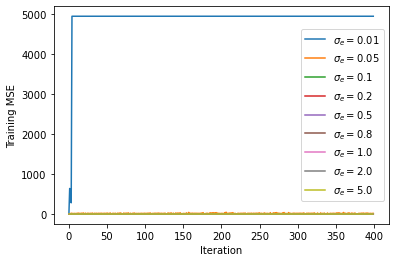

In [3]:
# Learning curve of training MSE

l1 = plt.plot(QKMCC_trainMSE_store[0])
l2 = plt.plot(QKMCC_trainMSE_store[1])
l3 = plt.plot(QKMCC_trainMSE_store[2])
l4 = plt.plot(QKMCC_trainMSE_store[3])
l5 = plt.plot(QKMCC_trainMSE_store[4])
l6 = plt.plot(QKMCC_trainMSE_store[5])
l7 = plt.plot(QKMCC_trainMSE_store[6])
l8 = plt.plot(QKMCC_trainMSE_store[7])
l9 = plt.plot(QKMCC_trainMSE_store[8])
plt.xlabel('Iteration')
plt.ylabel('Training MSE')
plt.legend([r'$\sigma_e=0.01$', r'$\sigma_e=0.05$', r'$\sigma_e=0.1$', r'$\sigma_e=0.2$', r'$\sigma_e=0.5$', r'$\sigma_e=0.8$', r'$\sigma_e=1.0$', r'$\sigma_e=2.0$', r'$\sigma_e=5.0$'])
plt.show()

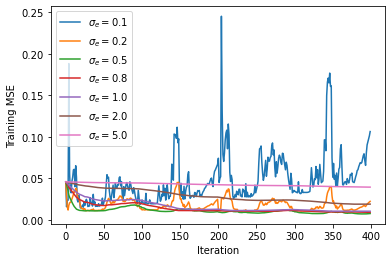

In [4]:
# Learning curve of training MSE

l1 = plt.plot(QKMCC_trainMSE_store[2])
l2 = plt.plot(QKMCC_trainMSE_store[3])
l3 = plt.plot(QKMCC_trainMSE_store[4])
l4 = plt.plot(QKMCC_trainMSE_store[5])
l5 = plt.plot(QKMCC_trainMSE_store[6])
l6 = plt.plot(QKMCC_trainMSE_store[7])
l7 = plt.plot(QKMCC_trainMSE_store[8])
plt.xlabel('Iteration')
plt.ylabel('Training MSE')
plt.legend([r'$\sigma_e=0.1$', r'$\sigma_e=0.2$', r'$\sigma_e=0.5$', r'$\sigma_e=0.8$', r'$\sigma_e=1.0$', r'$\sigma_e=2.0$', r'$\sigma_e=5.0$'])
plt.show()

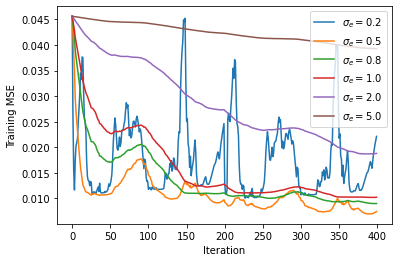

In [5]:
# Learning curve of training MSE

l1 = plt.plot(QKMCC_trainMSE_store[3])
l2 = plt.plot(QKMCC_trainMSE_store[4])
l3 = plt.plot(QKMCC_trainMSE_store[5])
l4 = plt.plot(QKMCC_trainMSE_store[6])
l5 = plt.plot(QKMCC_trainMSE_store[7])
l6 = plt.plot(QKMCC_trainMSE_store[8])
plt.xlabel('Iteration')
plt.ylabel('Training MSE')
plt.legend([r'$\sigma_e=0.2$', r'$\sigma_e=0.5$', r'$\sigma_e=0.8$', r'$\sigma_e=1.0$', r'$\sigma_e=2.0$', r'$\sigma_e=5.0$'])
plt.show()

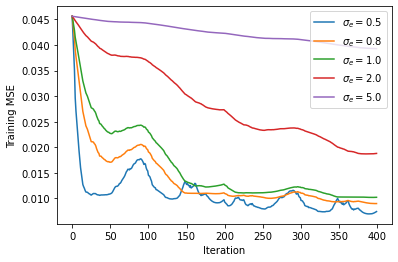

In [6]:
# Learning curve of training MSE

l1 = plt.plot(QKMCC_trainMSE_store[4])
l2 = plt.plot(QKMCC_trainMSE_store[5])
l3 = plt.plot(QKMCC_trainMSE_store[6])
l4 = plt.plot(QKMCC_trainMSE_store[7])
l5 = plt.plot(QKMCC_trainMSE_store[8])
plt.xlabel('Iteration')
plt.ylabel('Training MSE')
plt.legend([r'$\sigma_e=0.5$', r'$\sigma_e=0.8$', r'$\sigma_e=1.0$', r'$\sigma_e=2.0$', r'$\sigma_e=5.0$'])
plt.show()

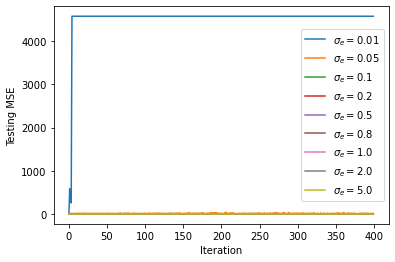

In [7]:
# Learning curve of testing MSE

l1 = plt.plot(QKMCC_testMSE_store[0])
l2 = plt.plot(QKMCC_testMSE_store[1])
l3 = plt.plot(QKMCC_testMSE_store[2])
l4 = plt.plot(QKMCC_testMSE_store[3])
l5 = plt.plot(QKMCC_testMSE_store[4])
l6 = plt.plot(QKMCC_testMSE_store[5])
l7 = plt.plot(QKMCC_testMSE_store[6])
l8 = plt.plot(QKMCC_testMSE_store[7])
l9 = plt.plot(QKMCC_testMSE_store[8])
plt.xlabel('Iteration')
plt.ylabel('Testing MSE')
plt.legend([r'$\sigma_e=0.01$', r'$\sigma_e=0.05$', r'$\sigma_e=0.1$', r'$\sigma_e=0.2$', r'$\sigma_e=0.5$', r'$\sigma_e=0.8$', r'$\sigma_e=1.0$', r'$\sigma_e=2.0$', r'$\sigma_e=5.0$'])
plt.show()

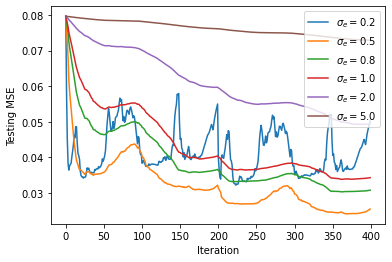

In [8]:
# Learning curve of testing MSE

l1 = plt.plot(QKMCC_testMSE_store[3])
l2 = plt.plot(QKMCC_testMSE_store[4])
l3 = plt.plot(QKMCC_testMSE_store[5])
l4 = plt.plot(QKMCC_testMSE_store[6])
l5 = plt.plot(QKMCC_testMSE_store[7])
l6 = plt.plot(QKMCC_testMSE_store[8])
plt.xlabel('Iteration')
plt.ylabel('Testing MSE')
plt.legend([r'$\sigma_e=0.2$', r'$\sigma_e=0.5$', r'$\sigma_e=0.8$', r'$\sigma_e=1.0$', r'$\sigma_e=2.0$', r'$\sigma_e=5.0$'])
plt.show()

In [17]:
## =================================================== Q1 AND Q2 ======================================================##